## Setup

The first step is to sync this notebook with Google Drive, and change directory to gerumo repository.

In [1]:
%cd /home/bapanes/Research-Now/gerumo

/home/bapanes/Research-Now/gerumo


## Load Gerumo and extra modules.

In [3]:
from gerumo import *

import logging
import time
from os import path

import numpy as np
from tensorflow import keras
from tensorflow.keras.utils import plot_model

import json
from tqdm.notebook import tqdm

## Load Configuration file

In [0]:
#config_file = "/content/drive/My Drive/Projects/gerumo/train/config/umonna_sst_colab.json"
config_file = "/content/drive/My Drive/Projects/gerumo/train/config/umonna_mst_colab.json"
#config_file = "/content/drive/My Drive/Projects/gerumo/train/config/umonna_lst_colab.json"

In [4]:
print(f"Loading config from: {config_file}")
with open(config_file) as cfg_file:
    config = json.load(cfg_file)

# Model
model_name = config["model_name"]
model_constructor = MODELS[config["model_constructor"]]
model_extra_params = config["model_extra_params"]

# Dataset Parameters
output_folder = config["output_folder"]
replace_folder_train = config["replace_folder_train"]
replace_folder_validation = config["replace_folder_validation"]
train_events_csv    = config["train_events_csv"]
train_telescope_csv = config["train_telescope_csv"]
validation_events_csv    = config["validation_events_csv"]
validation_telescope_csv = config["validation_telescope_csv"]

# Input and Target Parameters 
telescope = config["telescope"]
min_observations = config["min_observations"]
input_image_mode = config["input_image_mode"]
input_image_mask = config["input_image_mask"]
input_features = config["input_features"]
targets = config["targets"]
target_mode = "one_cell" #config["target_mode"]
target_shapes = config["target_shapes"]
target_domains = config["target_domains"]
target_resolutions = get_resolution(targets, target_domains, target_shapes)

# Prepare Generator target_mode_config 
target_mode_config = {
    "target_shapes":      tuple([target_shapes[target]      for target in targets]),
    "target_domains":     tuple([target_domains[target]     for target in targets]),
    "target_resolutions": tuple([target_resolutions[target] for target in targets])
}
if target_mode == "probability_map":
    target_sigmas = config["target_sigmas"]
    target_mode_config["target_sigmas"] = tuple([target_sigmas[target] for target in targets])

# Training Parameters
batch_size = 64 #config["batch_size"]
epochs = config["epochs"]
loss = config["loss"]
learning_rate = config["learning_rate"]
save_checkpoints = config["save_checkpoints"]

Loading config from: /content/drive/My Drive/Projects/gerumo/train/config/umonna_mst_colab.json


In [5]:
import pprint
pprint.pprint(config, width=1)

{'batch_size': 32,
 'epochs': 30,
 'input_features': ['x',
                    'y'],
 'input_image_mask': True,
 'input_image_mode': 'simple-shift',
 'learning_rate': 0.1,
 'loss': 'crossentropy',
 'min_observations': 3,
 'model_constructor': 'umonna_unit',
 'model_extra_params': {'latent_variables': 600},
 'model_name': 'UMONNA_UNIT_MST_V2',
 'output_folder': '/content/drive/Shared '
                  'drives/umonna/data/output',
 'plot_only': False,
 'replace_folder_test': '/content/drive/Shared '
                        'drives/umonna/data/data/raw/Test',
 'replace_folder_train': '/content/drive/Shared '
                         'drives/umonna/data/data/raw/Train',
 'replace_folder_validation': '/content/drive/Shared '
                              'drives/umonna/data/data/raw/Train',
 'save_checkpoints': True,
 'save_plot': False,
 'summary': False,
 'target_domains': {'alt': [1.05,
                            1.382],
                    'az': [-0.52,
                           0.5

## Load Dataset

In [0]:
import pandas as pd

In [0]:
# Prepare datasets
train_dataset      = load_dataset(train_events_csv, train_telescope_csv, replace_folder_train)
validation_dataset = load_dataset(validation_events_csv, validation_telescope_csv, replace_folder_validation)

train_dataset = aggregate_dataset(train_dataset, az=True, log10_mc_energy=True)
train_dataset = filter_dataset(train_dataset, telescope, min_observations, target_domains)

validation_dataset = aggregate_dataset(validation_dataset, az=True, log10_mc_energy=True, hdf5_file=True)
validation_dataset = filter_dataset(validation_dataset, telescope, min_observations, target_domains)

# FIX ME: skip hdf5 error
train_dataset = pd.concat([train_dataset[:148*64], train_dataset[160*64:160*64 + 1000*64]])

# Preprocessing pipes
preprocess_input_pipes = []
preprocess_output_pipes = []

In [8]:
train_dataset.groupby("type")[["alt", "az","log10_mc_energy"]].describe()

alt                      ... log10_mc_energy                    
                count      mean       std  ...             50%       75%       max
type                                       ...                                    
MST_FlashCam  73472.0  1.217794  0.044395  ...       -0.250232  0.396216  2.432826

[1 rows x 24 columns]

In [9]:
validation_dataset.groupby("type")[["alt", "az","log10_mc_energy"]].describe()

alt                     ... log10_mc_energy                    
                count      mean      std  ...             50%       75%       max
type                                      ...                                    
MST_FlashCam  42764.0  1.218953  0.04351  ...       -0.213807  0.443999  2.407454

[1 rows x 24 columns]

## Data Generators

In [0]:
# Generators
train_generator = AssemblerUnitGenerator(train_dataset, batch_size, 
                                        input_image_mode=input_image_mode, 
                                        input_image_mask=input_image_mask, 
                                        input_features=input_features,
                                        targets=targets,
                                        target_mode=target_mode, 
                                        target_mode_config=target_mode_config,
                                        preprocess_input_pipes=preprocess_input_pipes,
                                        preprocess_output_pipes=preprocess_output_pipes
                                        )
validation_generator = AssemblerUnitGenerator(validation_dataset, batch_size//2, 
                                                input_image_mode=input_image_mode,
                                                input_image_mask=input_image_mask, 
                                                input_features=input_features,
                                                targets=targets,
                                                target_mode=target_mode, 
                                                target_mode_config=target_mode_config,
                                                preprocess_input_pipes=preprocess_input_pipes,
                                                preprocess_output_pipes=preprocess_output_pipes
                                                )

### Generator sample

In [11]:
i = 4
batch_i = train_generator[i]
print(f"Batch size: {batch_i[0][0].shape[0]}")
print()
print(f"Input mode: {input_image_mode}")
print(f"Input image shape: {batch_i[0][0].shape[1:]}")
print(f"Input features: {input_features}")
print(f"Input features shape: {batch_i[0][1].shape[1:]}")
print()
print(f"Target mode: {target_mode}")
print(f"Target shape: {batch_i[1].shape[1:]}")

img_sample =batch_i[0][0][0]
feature_sample = batch_i[0][1][0]
target_sample = batch_i[1][0]

#show_input_sample(img_sample, input_image_mode, feature_sample, make_simple=False)

#show_target_sample(target_sample, targets, target_mode, target_domains)

Batch size: 64

Input mode: simple-shift
Input image shape: (2, 84, 29, 3)
Input features: ['x', 'y']
Input features shape: (2,)

Target mode: one_cell
Target shape: (81, 81)


In [12]:
# Debug: Check if train dataset is loadable
for i in tqdm(range(len(train_generator))):
  _ = train_generator[i]

# Debug: Check if train dataset is loadable
for i in tqdm(range(len(validation_generator))):
  _ = validation_generator[i]

## Compile model 

In [13]:
# CallBacks
callbacks = []
#if save_checkpoints:
if False:
    # Checkpoint parameters
    checkpoint_filepath = "%s_%s_%s_e{epoch:03d}_{val_loss:.4f}.h5"%(model_name, telescope, loss)
    checkpoint_filepath = path.join(output_folder, checkpoint_filepath)
    callbacks.append(
        keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor='val_loss', 
              verbose=1, save_weights_only=False, mode='min', save_best_only=True))

# Train
input_img_shape = INPUT_SHAPE[f"{input_image_mode}-mask" if input_image_mask else input_image_mode][telescope]
input_features_shape = (len(input_features),)
target_shapes = target_mode_config["target_shapes"]
model = model_constructor(telescope, input_image_mode, input_image_mask, 
                input_img_shape, input_features_shape,
                targets, target_mode, 
                target_shapes=target_shapes, 
                **model_extra_params)

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


### Summary model

In [0]:
#model.summary()

In [0]:
#plot_model(model, to_file="/content/model.png", show_shapes=True)

### Loss Function

In [0]:
## Loss function
if loss == "crossentropy":
    loss_ = crossentropy_loss(dimensions=len(targets))
elif loss == "hellinger":
    loss_ = hellinger_loss()
elif loss == "mse":
    loss_ = mse_loss()
elif loss == "distance":
    loss_ = mean_distance_loss(target_shapes)

In [0]:
model.compile(
    #optimizer=keras.optimizers.Adam(lr=learning_rate),
    optimizer=keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.01, nesterov=True),
    loss=loss_
)

## Fit Model

In [0]:
epochs = 5

In [17]:
start_time = time.time()
history = model.fit(
    train_generator,
    epochs = epochs,
    verbose = 1,
    validation_data = validation_generator,
    validation_steps = len(validation_generator),
    callbacks = callbacks,
    #use_multiprocessing = True,
    #workers = 4,
    max_queue_size = 75
)
training_time = (time.time() - start_time)/60.0

Epoch 1/5
1148/1148 [==============================] - 214s 186ms/step - loss: 7.0523 - val_loss: 6.1833
Epoch 2/5
1148/1148 [==============================] - 199s 174ms/step - loss: 6.2566 - val_loss: 5.5383
Epoch 3/5
1148/1148 [==============================] - 209s 182ms/step - loss: 5.8849 - val_loss: 8.0343
Epoch 4/5
1148/1148 [==============================] - 200s 174ms/step - loss: 5.6226 - val_loss: 5.2906
Epoch 5/5
1148/1148 [==============================] - 195s 170ms/step - loss: 5.4082 - val_loss: 5.0496


## Show some predictions

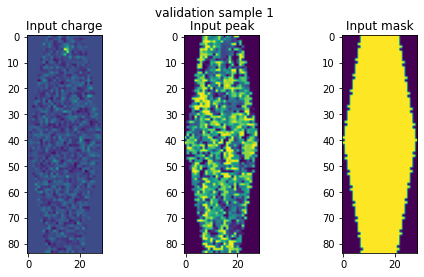

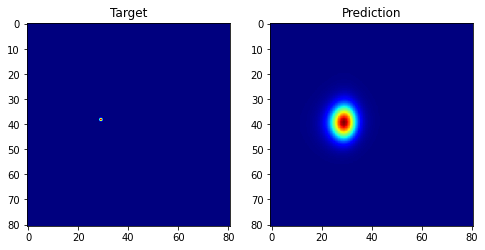

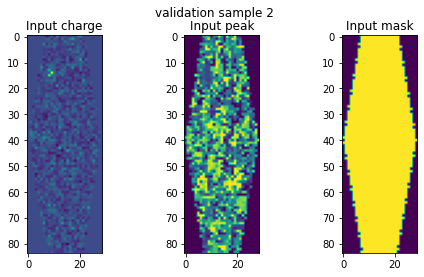

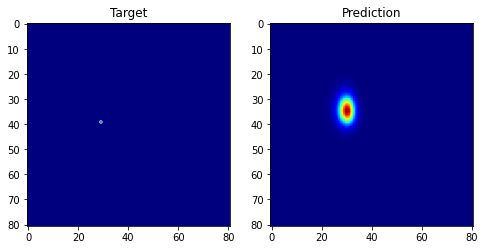

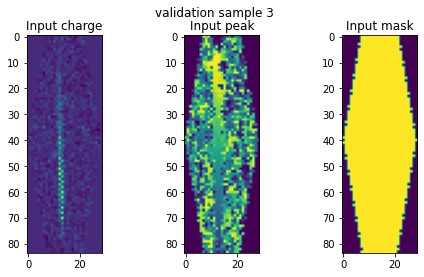

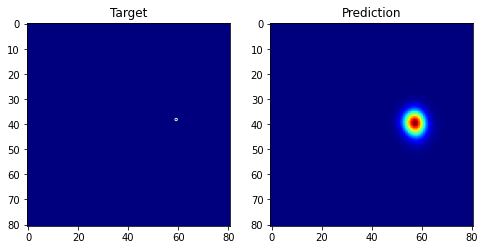

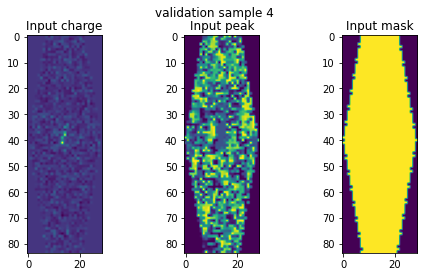

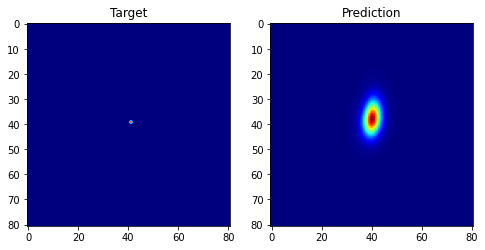

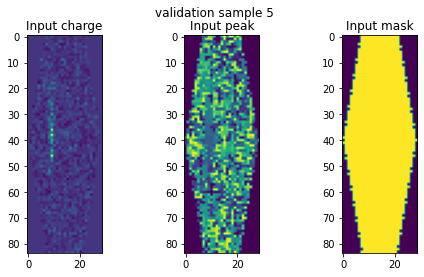

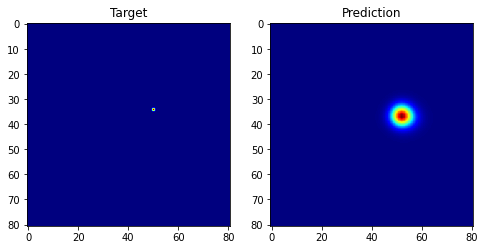

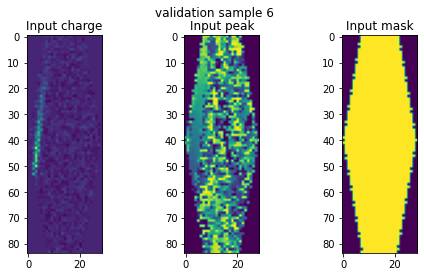

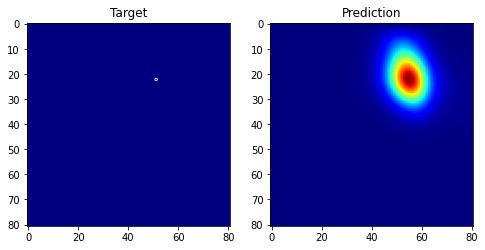

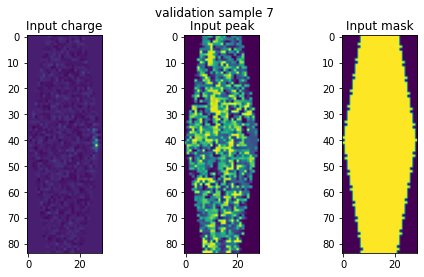

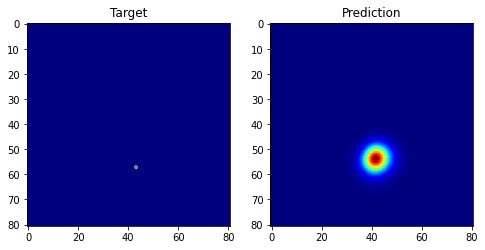

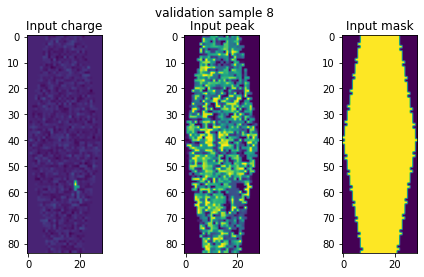

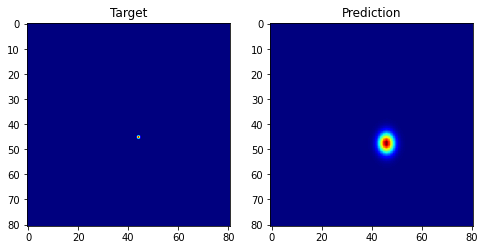

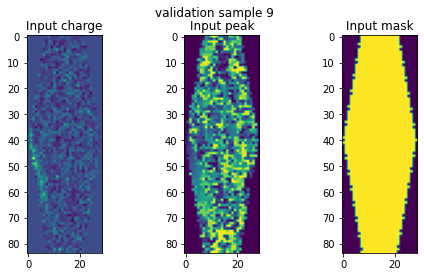

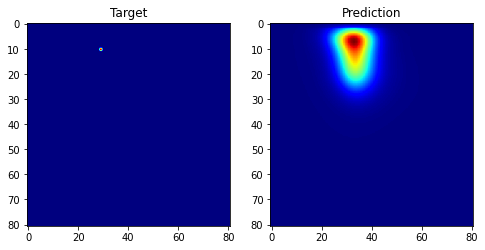

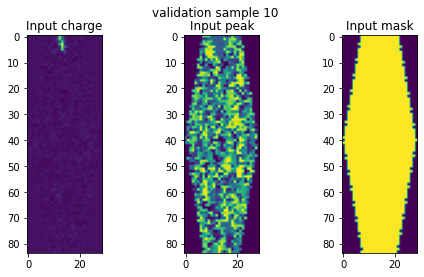

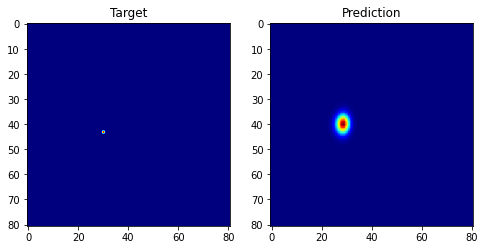

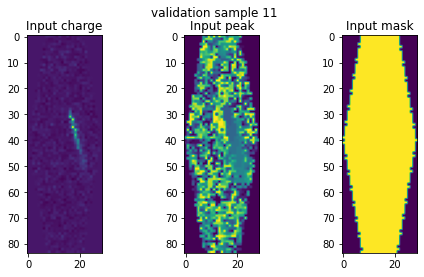

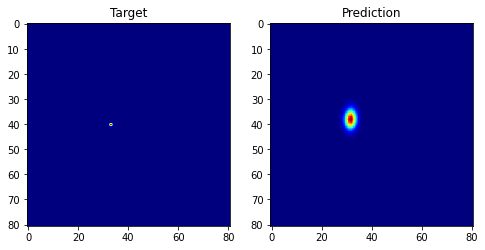

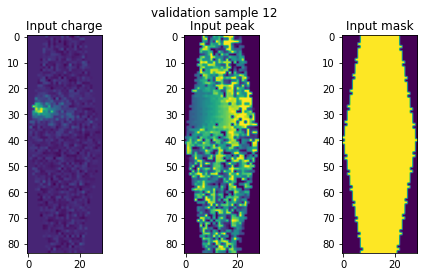

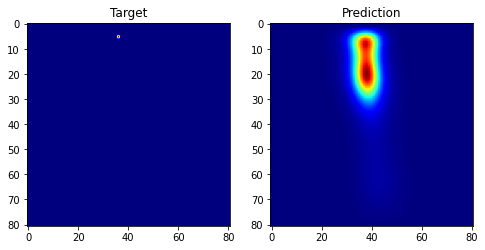

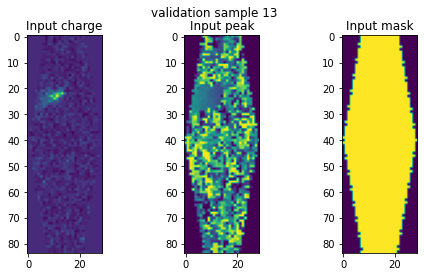

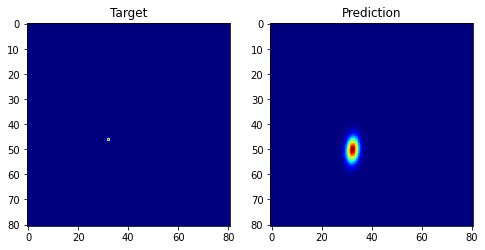

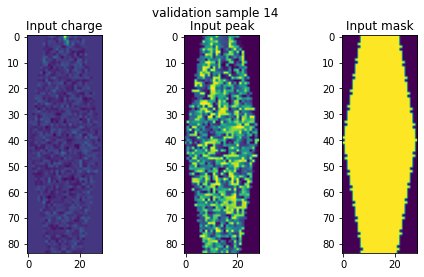

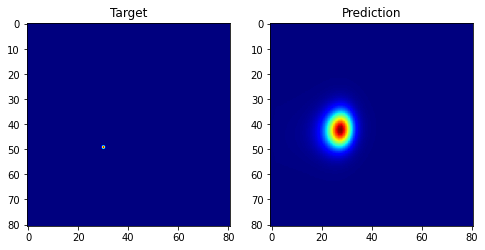

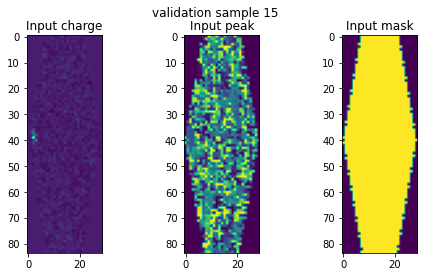

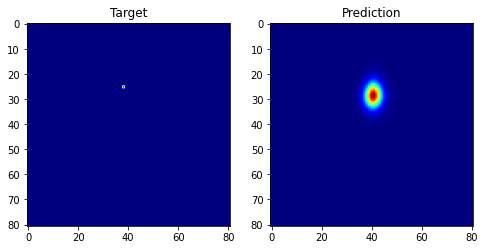

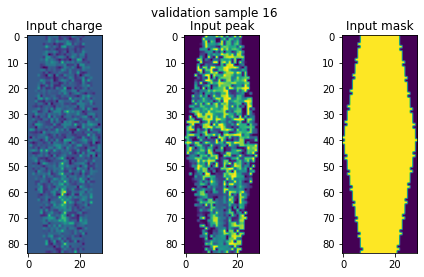

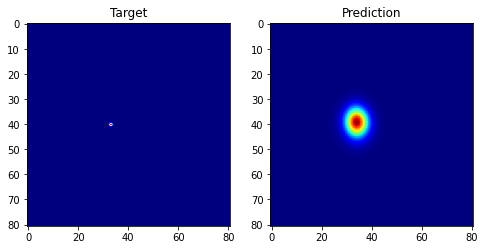

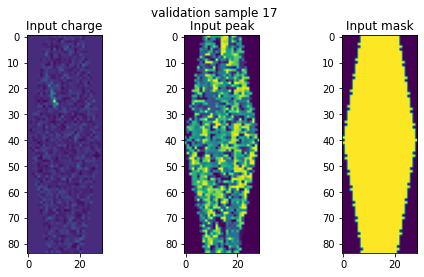

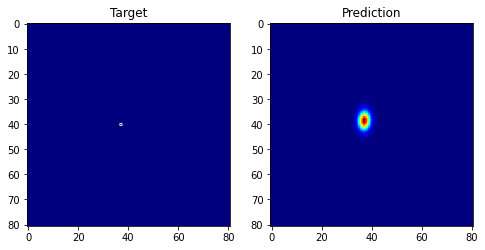

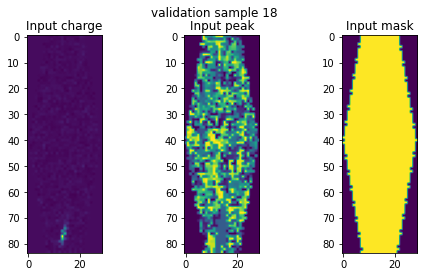

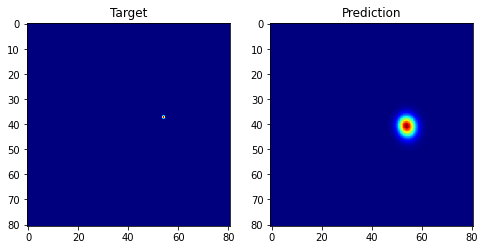

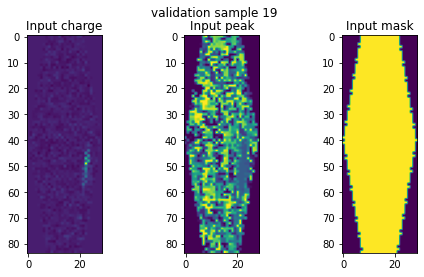

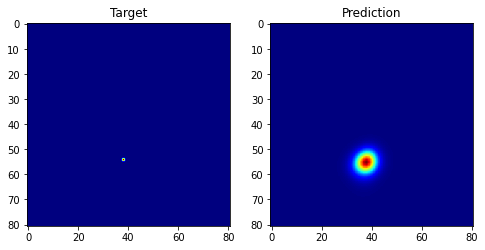

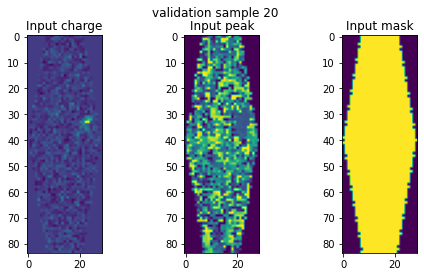

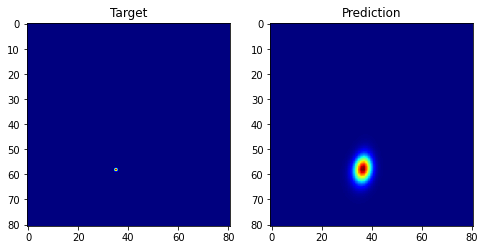

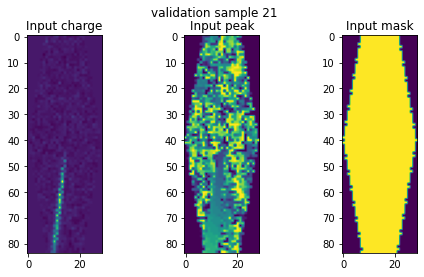

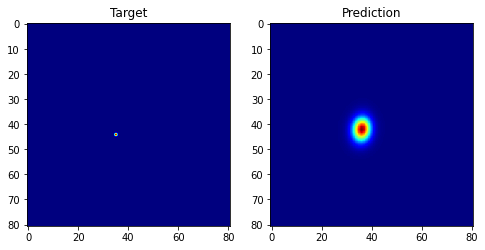

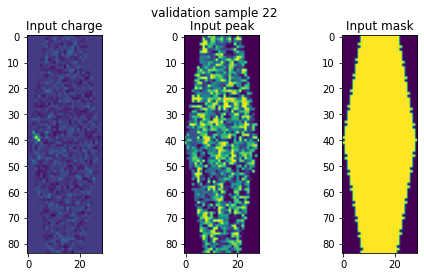

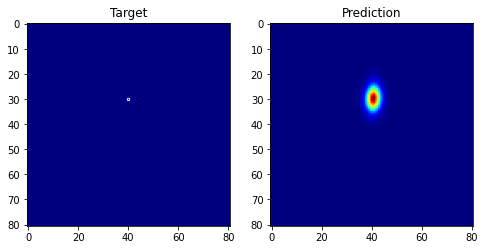

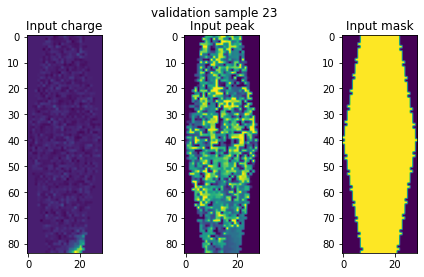

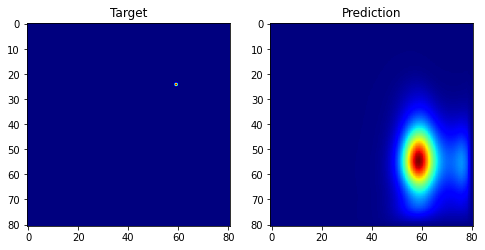

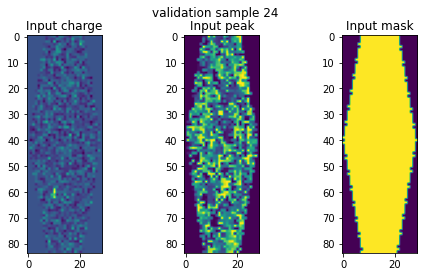

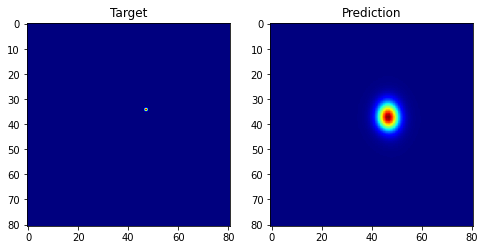

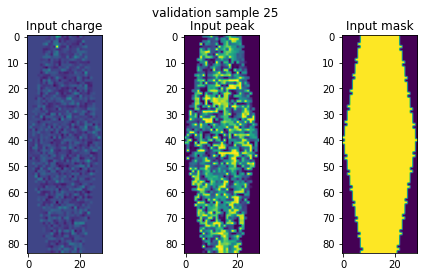

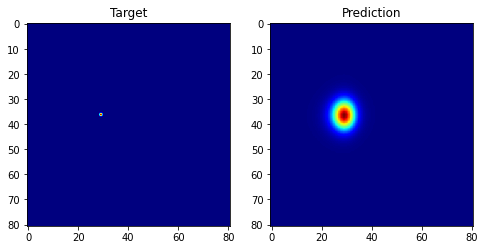

In [18]:
import matplotlib.pyplot as plt

# Validate
s = 0
for j in range(0,50,2):
  s += 1
  batch_0 = validation_generator[j]
  i=np.random.randint(len(batch_0[1]))
  prediction = model.predict(batch_0[0])[i]
  target = batch_0[1][i]
  input_img_e = batch_0[0][0][i][0][:,:,0]
  input_img_t = batch_0[0][0][i][0][:,:,1]
  input_img_m = batch_0[0][0][i][0][:,:,2]

  # TODO: Add plots to viz module
  fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(8, 4))
  fig.suptitle(f'validation sample {s}')
  ax0.imshow(input_img_e)
  ax0.set_title(f"Input charge")
  ax1.imshow(input_img_t)
  ax1.set_title(f"Input peak")
  ax2.imshow(input_img_m)
  ax2.set_title(f"Input mask")
  plt.show()

  _, (ax2, ax3)  = plt.subplots(1, 2, figsize=(8, 4))
  ax2.imshow(target, cmap="jet")
  ax2.set_title(f"Target")

  ax3.imshow(prediction, cmap="jet")
  ax3.set_title("Prediction")
  plt.show()